In [15]:
!pip install tensorflow numpy

In [16]:
!pip install opencv-python

In [24]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [18]:
print("Loading MNIST dataset...")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

Loading MNIST dataset...


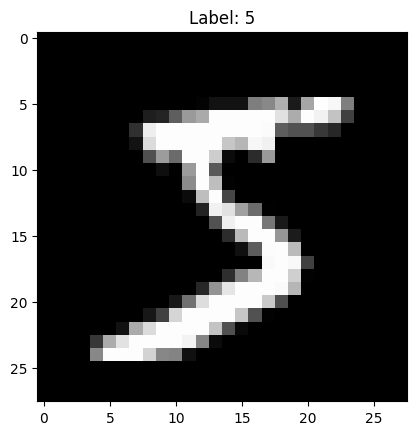

In [19]:
# Normalize to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Add channel dimension: (N, 28, 28) -> (N, 28, 28, 1)
train_images = train_images[..., None]
test_images = test_images[..., None]

plt.imshow(train_images[0, :, :, 0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()


In [20]:
def create_cnn_model():
    model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
    return model




In [21]:
predictions = model.predict(test_images[:1])
print(predictions)
print(f'\n the predicted digit is {predictions[0].argmax()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[0.09644067 0.09476215 0.10913429 0.08787974 0.09569839 0.10443132
  0.10141443 0.09570049 0.11058269 0.10395575]]

 the predicted digit is 8


In [22]:
model = create_cnn_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
print("Training the model on Task A...")
model.fit(train_images, train_labels, epochs=5, batch_size=128, validation_split=0.1)

acc_A_before = model.evaluate(test_images, test_labels, verbose=0)[1]
print("Task A accuracy before Task B:", acc_A_before)


Training the model on Task A...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.7833 - loss: 0.6592 - val_accuracy: 0.9828 - val_loss: 0.0607
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9664 - loss: 0.1114 - val_accuracy: 0.9858 - val_loss: 0.0502
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9765 - loss: 0.0785 - val_accuracy: 0.9900 - val_loss: 0.0374
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9803 - loss: 0.0641 - val_accuracy: 0.9900 - val_loss: 0.0345
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9833 - loss: 0.0546 - val_accuracy: 0.9900 - val_loss: 0.0353
Task A accuracy before Task B: 0.9900000095367432


In [25]:
def permute_mnist(images, seed=0):
    np.random.seed(seed)
    perm = np.random.permutation(28 * 28)
    images_flat = images.reshape(-1, 28 * 28)
    images_perm = images_flat[:, perm]
    return images_perm.reshape(-1, 28, 28, 1)

train_images_B = permute_mnist(train_images, seed=42)
test_images_B = permute_mnist(test_images, seed=42)



In [26]:
print("Compiling the model for Task B...")
model.fit(train_images_B, train_labels,
          epochs=5,
          batch_size=128)

acc_A_after = model.evaluate(test_images, test_labels, verbose=0)[1]
acc_B = model.evaluate(test_images_B, test_labels, verbose=0)[1]

Compiling the model for Task B...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.7258 - loss: 0.8462
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.9156 - loss: 0.2742
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.9309 - loss: 0.2240
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.9431 - loss: 0.1850
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9479 - loss: 0.1663


In [27]:
forgetting_baseline = acc_A_before - acc_A_after
avg_acc_baseline = (acc_A_after + acc_B) / 2

print("Results without mitigation")
print("Task A after Task B:", acc_A_after)
print("Task B accuracy:", acc_B)
print("Forgetting:", forgetting_baseline)


Results without mitigation
Task A after Task B: 0.7360000014305115
Task B accuracy: 0.9645000100135803
Forgetting: 0.2540000081062317


In [30]:
buffer_size = 2000
buffer_images = train_images[:buffer_size]
buffer_labels = train_labels[:buffer_size]

In [31]:
model_rehearsal = create_cnn_model()
model_rehearsal.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train Task A
model_rehearsal.fit(train_images, train_labels,
                    epochs=5,
                    batch_size=128)

acc_A_before_r = model_rehearsal.evaluate(
    test_images, test_labels, verbose=0)[1]

# mixed replay
mixed_images = np.concatenate([train_images_B, buffer_images])
mixed_labels = np.concatenate([train_labels, buffer_labels])

model_rehearsal.fit(mixed_images, mixed_labels,
                    epochs=5,
                    batch_size=128)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.8143 - loss: 0.5890
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.9680 - loss: 0.1072
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9760 - loss: 0.0777
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9812 - loss: 0.0620
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.9836 - loss: 0.0514
Epoch 1/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.7143 - loss: 0.8698
Epoch 2/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.9105 - loss: 0.2968
Epoch 3/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9284 - loss: 0.2314
Epoch 4/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9418 - loss: 0.1925
Epoch 5/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9453 - loss: 0.1761


In [33]:
acc_A_after_r = model_rehearsal.evaluate(
    test_images, test_labels, verbose=0)[1]

acc_B_r = model_rehearsal.evaluate(
    test_images_B, test_labels, verbose=0)[1]


forgetting_rehearsal = acc_A_before_r - acc_A_after_r
avg_acc_rehearsal = (acc_A_after_r + acc_B_r) / 2
print("Results with rehearsal mitigation")
print("Task A after Task B:", acc_A_after_r)
print("Task B accuracy:", acc_B_r)
print("Forgetting:", forgetting_rehearsal)


Results with rehearsal mitigation
Task A after Task B: 0.9796000123023987
Task B accuracy: 0.9642999768257141
Forgetting: 0.010599970817565918


In [38]:
# EWC method Elastic Weight Consolidation
model_reg = create_cnn_model()
model_reg.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_reg.fit(train_images, train_labels,
              epochs=5,
              batch_size=128)

old_weights = model_reg.get_weights()
lambda_ewc = 0.01

# computing EWC
def ewc_loss(y_true, y_pred):
    base_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred)
    reg_loss = 0
    for w, w_old in zip(model_reg.trainable_weights, old_weights):
        reg_loss += tf.reduce_sum(tf.square(w - w_old))
    return base_loss + lambda_ewc * reg_loss


Epoch 1/5


469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.8095 - loss: 0.6004
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.9682 - loss: 0.1099
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.9762 - loss: 0.0784
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9795 - loss: 0.0691
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9817 - loss: 0.0592


In [39]:
model_reg.compile(
    optimizer='adam',
    loss=ewc_loss,
    metrics=['accuracy']
)

model_reg.fit(train_images_B, train_labels,
              epochs=5,
              batch_size=128)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.6006 - loss: 1.4244
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.8028 - loss: 0.9620
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8153 - loss: 0.9352
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.8283 - loss: 0.9055
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - accuracy: 0.8313 - loss: 0.9054


In [40]:
acc_A_after_reg = model_reg.evaluate(
    test_images, test_labels, verbose=0)[1]
acc_B_reg = model_reg.evaluate(
    test_images_B, test_labels, verbose=0)[1]

forgetting_reg = acc_A_before - acc_A_after_reg
avg_acc_reg = (acc_A_after_reg + acc_B_reg) / 2
print("Results with EWC mitigation")
print("Task A after Task B:", acc_A_after_reg)
print("Task B accuracy:", acc_B_reg)
print("Forgetting:", forgetting_reg)


Results with EWC mitigation
Task A after Task B: 0.9581999778747559
Task B accuracy: 0.9025999903678894
Forgetting: 0.031800031661987305


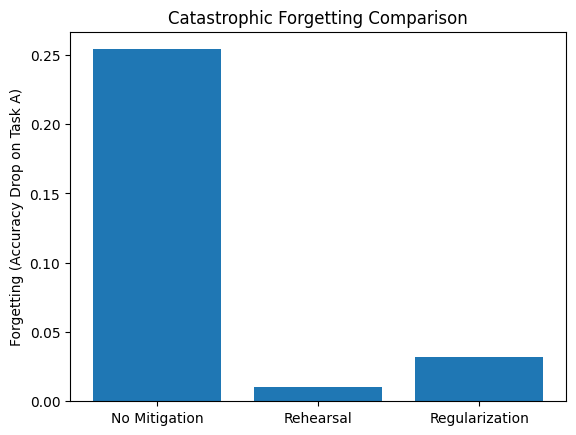

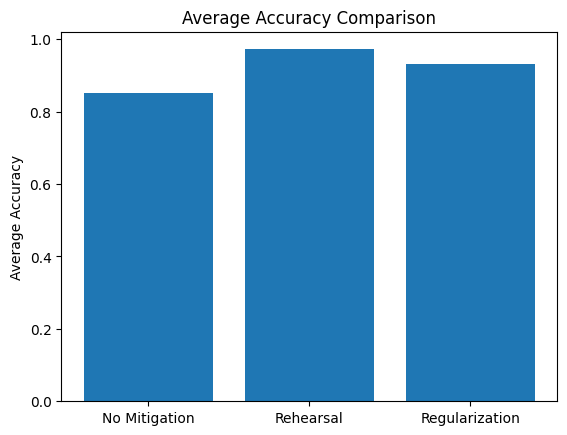

In [41]:
methods = ['No Mitigation', 'Rehearsal', 'Regularization']
forgetting_values = [
    forgetting_baseline,
    forgetting_rehearsal,
    forgetting_reg
]
avg_acc_values = [
    avg_acc_baseline,
    avg_acc_rehearsal,
    avg_acc_reg
    
]
plt.figure()
plt.bar(methods, forgetting_values)
plt.ylabel("Forgetting (Accuracy Drop on Task A)")
plt.title("Catastrophic Forgetting Comparison")
plt.show()

# Average Accuracy Plot
plt.figure()
plt.bar(methods, avg_acc_values)
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy Comparison")
plt.show()
              
